In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
python3 = True

# 0 - Intruduction: usefull actions

The goal of this work is to build model able to predict probability for a client to leave ENEL (Churn)

## 0.1- Import of useful packages and modules

In [2]:
import pandas as pd, os, sys
pd.set_option('max_colwidth', None)
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

import pickle
from keras.models import Input, Model
from keras.layers import Dense

Using TensorFlow backend.


## 0.2- Environment variables setting

In [3]:
# Setting environment variables
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")
if python3: os.environ['PYSPARK_PYTHON'] = "vsb/CI_conda_env_py3/bin/python"

## 0.2- Spark configuration 

In [4]:
# Importing the Spark Configurator and the Spark Session builder
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as spark_functions
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics
from pyspark.sql.window import Window

# Stopping the current session if exists
try:
    session.stop()
except:
    print()
   
# Setting up the spark configurator  
conf = SparkConf()
conf.set('spark.serializer', "org.apache.spark.serializer.KryoSerializer")       
conf.set('spark.executor.memory', '64g')
conf.set('spark.driver.memory', '64g')
conf.set('spark.executor.cores', '3')
conf.set('spark.driver.cores', '3')
conf.set('spark.dynamicAllocation.enabled', 'true')
conf.set('spark.executor.instances', '4')
conf.set('spark.dynamicAllocation.minExecutors', '4')
conf.set('spark.dynamicAllocation.maxExecutors', '8')
conf.set('spark.executor.memoryOverhead', '8096')
conf.set('spark.driver.memoryOverhead', '8096')
conf.set('spark.driver.maxResultSize', '16g')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.setAppName('DA_Data_Transformation')
if python3: conf.set("spark.yarn.dist.archives", "/home/anxadvuser/anx_adv_achurn/env_conda_py3.zip#vsb")

# Creating the spark session object
session = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()

In [19]:
# Let's fetch the output of the first step of feature selection as input of the current step
#input_data = session.read.parquet("/bda/anx_adv_achurn/t_bda_anx_dt_ach_b2b_master_table_train")
input_data_convert_cat_to_num = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_test_supervised_fs_step1")
#servizi = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_servizi")
#servizi_mercato_provenienza = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_SERVIZI_MERCATO_PROVENIENZA")
#clienti = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_cliente")
#geomarketing_arricchita = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_geomarketing_arricchita")
#marketing = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_MARKETING")
#cliente_cv = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_cliente_cv")
#servizio_fattura = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_servizio_fattura")
#tipologia_pagamento = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_FATTURATO_TIPOLOGIA_PAGAMENTO")
#fatturato_isu = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_aa_fatturato_isu")
#mercato_provenienza = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_SERVIZI_MERCATO_PROVENIENZA")
#geomarketing_istat = session.read.parquet("/bds/anx_adv_achurn/t_bds_anx_dt_ach_geomarketing_istat")

# 1 - Data Tranformation

### 1.1 - Checking the imbalance of categorical target (class imbalance)

A dataset is said to be “highly class imbalanced” if a sample from one target class is significantly higher in number than others. This can be treated as a special case of the previous “low entropy of categorical attributes.” In an imbalanced dataset, the class with a higher number of instances is called a major class, while those with relatively fewer instances are called minor classes.

In this case, most of the classifiers are biased towards the major classes and, hence, display poor classification rates on minor classes. It is also possible that the classifier predicts everything as a major class and ignores the minor class.

In [6]:
input_data_convert_cat_to_num.groupBy('val_churn_2_months').count().show()

+------------------+--------+
|val_churn_2_months|   count|
+------------------+--------+
|               0.0|25811807|
|               1.0|  397199|
+------------------+--------+



In [14]:
input_data_convert_cat_to_num.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+-------+
|val_t0_year|val_t0_month|val_churn_2_months|  count|
+-----------+------------+------------------+-------+
|       2019|           5|               0.0|1610272|
|       2019|           5|               1.0|  42500|
|       2019|           6|               0.0|1622115|
|       2019|           6|               1.0|  43811|
|       2019|           7|               0.0|1645209|
|       2019|           7|               1.0|  36331|
|       2019|           8|               0.0|1665150|
|       2019|           8|               1.0|  32783|
|       2019|           9|               0.0|3711238|
|       2019|           9|               1.0|  75173|
|       2019|          10|               0.0|1672991|
|       2019|          10|               1.0|  52841|
|       2019|          11|               0.0|1678726|
|       2019|          11|               1.0|  49663|
|       2019|          12|               0.0|1688703|
|       2019|          12|  

First of all, let's split the data into train set (80%) and test set (20%). The splitting will be stratified over the following columns:
* val_t0_year
* val_t0_month
* val_churn_2_months

In [7]:
# add the column to be used to sample the data
input_data_convert_cat_to_num_for_sample = input_data_convert_cat_to_num.withColumn('sample_by_column', 
                                                                                 spark_functions.concat(
                                                                                     spark_functions.col('val_t0_year'), 
                                                                                     spark_functions.col('val_t0_month'), 
                                                                                     spark_functions.col('val_churn_2_months')
                                                                                 )
                                                                                )

# add the column to be used as the join key to get the test set
input_data_convert_cat_to_num_for_sample = input_data_convert_cat_to_num_for_sample.withColumn("row_id", spark_functions.monotonically_increasing_id())

In [8]:
fractions = input_data_convert_cat_to_num_for_sample.select("sample_by_column").distinct().withColumn("fraction", spark_functions.lit(0.8)).rdd.collectAsMap()
print(fractions)

{'2019111.0': 0.8, '201961.0': 0.8, '202030.0': 0.8, '202040.0': 0.8, '201951.0': 0.8, '2019101.0': 0.8, '202050.0': 0.8, '202060.0': 0.8, '201971.0': 0.8, '202020.0': 0.8, '201960.0': 0.8, '201990.0': 0.8, '201950.0': 0.8, '2019120.0': 0.8, '202010.0': 0.8, '201981.0': 0.8, '2019121.0': 0.8, '202011.0': 0.8, '2019100.0': 0.8, '2019110.0': 0.8, '201970.0': 0.8, '201991.0': 0.8, '201980.0': 0.8}


In [9]:
seed = 10
train_set = input_data_convert_cat_to_num_for_sample.stat.sampleBy("sample_by_column", fractions, seed)
train_set = train_set.dropDuplicates(['row_id'])
test_set = input_data_convert_cat_to_num_for_sample.join(train_set.select('row_id'), 
                                                         on = 'row_id', 
                                                         how = 'leftanti')

train_set = train_set.drop('sample_by_column')
train_set = train_set.drop('row_id')
test_set = test_set.drop('sample_by_column')
test_set = test_set.drop('row_id')

In [25]:
train_set.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+-------+
|val_t0_year|val_t0_month|val_churn_2_months|  count|
+-----------+------------+------------------+-------+
|       2019|           5|               0.0|1289004|
|       2019|           5|               1.0|  34025|
|       2019|           6|               0.0|1297999|
|       2019|           6|               1.0|  35040|
|       2019|           7|               0.0|1316562|
|       2019|           7|               1.0|  29077|
|       2019|           8|               0.0|1332283|
|       2019|           8|               1.0|  26299|
|       2019|           9|               0.0|2969216|
|       2019|           9|               1.0|  60128|
|       2019|          10|               0.0|1339254|
|       2019|          10|               1.0|  42274|
|       2019|          11|               0.0|1343498|
|       2019|          11|               1.0|  39822|
|       2019|          12|               0.0|1351835|
|       2019|          12|  

In [26]:
test_set.groupBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').count().orderBy('val_t0_year', 'val_t0_month', 'val_churn_2_months').show()

+-----------+------------+------------------+------+
|val_t0_year|val_t0_month|val_churn_2_months| count|
+-----------+------------+------------------+------+
|       2019|           5|               0.0|321268|
|       2019|           5|               1.0|  8475|
|       2019|           6|               0.0|324116|
|       2019|           6|               1.0|  8771|
|       2019|           7|               0.0|328647|
|       2019|           7|               1.0|  7254|
|       2019|           8|               0.0|332867|
|       2019|           8|               1.0|  6484|
|       2019|           9|               0.0|742022|
|       2019|           9|               1.0| 15045|
|       2019|          10|               0.0|333737|
|       2019|          10|               1.0| 10567|
|       2019|          11|               0.0|335228|
|       2019|          11|               1.0|  9841|
|       2019|          12|               0.0|336868|
|       2019|          12|               1.0| 

In [14]:
test_set.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5157136|
|               1.0|  79260|
+------------------+-------+



Now let us handle the imbalace situation on the training set.

In [27]:
train_set.groupBy('val_churn_2_months').count().show()

+------------------+--------+
|val_churn_2_months|   count|
+------------------+--------+
|               0.0|20654671|
|               1.0|  317939|
+------------------+--------+



#### 1.1.1 - Reducing the records of the over-represented class from 20 000 000 to 5 000 000 observations

As we can see, the number of zeros is extremely higher with respect to the number of ones. We have arround 20 000 000 observation for the 0 class which is huge. we are going to sample 5 000 000 of observations from this class and then oversample the 1 class to obtain in total 10 000 000 observations. The idea of oversampling, is to duplicate the samples from under-represented (1 in this case) class, to inflate the numbers till it reaches the same level as the dominant class (0 in this case).

In [10]:
# add the column to be used to sample the data
train_set_for_sample = train_set.withColumn('sample_by_column', 
                                             spark_functions.concat(
                                                 spark_functions.col('val_t0_year'), 
                                                 spark_functions.col('val_t0_month'), 
                                                 spark_functions.col('val_churn_2_months')
                                             )
                                            )

# add the column to be used as the join key to get the test set
train_set_for_sample = train_set_for_sample.withColumn("row_id", spark_functions.monotonically_increasing_id())

In [11]:
fractions = train_set_for_sample.select("sample_by_column").distinct().withColumn("fraction", 
                                                                                  spark_functions.when(train_set_for_sample.sample_by_column.like('%1.0'), 1).otherwise(0.25)
                                                                                 ).rdd.collectAsMap()

print(fractions)

{'2019111.0': 1.0, '201961.0': 1.0, '202030.0': 0.25, '202040.0': 0.25, '201951.0': 1.0, '2019101.0': 1.0, '202050.0': 0.25, '202060.0': 0.25, '201971.0': 1.0, '202020.0': 0.25, '201960.0': 0.25, '201990.0': 0.25, '201950.0': 0.25, '2019120.0': 0.25, '202010.0': 0.25, '201981.0': 1.0, '2019121.0': 1.0, '202011.0': 1.0, '2019100.0': 0.25, '2019110.0': 0.25, '201970.0': 0.25, '201991.0': 1.0, '201980.0': 0.25}


In [12]:
seed = 10
train_set = train_set_for_sample.stat.sampleBy("sample_by_column", fractions, seed)
train_set = train_set.dropDuplicates(['row_id'])

train_set = train_set.drop('sample_by_column')
train_set = train_set.drop('row_id')

In [30]:
train_set.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5164761|
|               1.0| 318249|
+------------------+-------+



#### 1.1.2 - Oversampling the under-represented class from 300 000 to 5 000 000 observations

In [13]:
major_df = train_set.filter(spark_functions.col("val_churn_2_months") == 0)
minor_df = train_set.filter(spark_functions.col("val_churn_2_months") == 1)
ratio = int(major_df.count()/minor_df.count())

a = range(ratio)
# duplicate the minority rows
oversampled_train_set = minor_df.withColumn("dummy", spark_functions.explode(spark_functions.array([spark_functions.lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train_set = major_df.unionAll(oversampled_train_set)

In [13]:
train_set.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5162592|
|               1.0|5087024|
+------------------+-------+



In [14]:
train_set.write.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set")

In [15]:
test_set.write.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_test_set")

## 1.1 - Converting categorical columns to numerical

In [5]:
train_set = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set")
test_set = session.read.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_test_set")

In [8]:
train_set.groupBy('val_churn_2_months').count().show()

+------------------+-------+
|val_churn_2_months|  count|
+------------------+-------+
|               0.0|5208579|
|               1.0|5101536|
+------------------+-------+



In [9]:
# This is the list of the 34 categorical features to be handled
categorical_features = ['cdc_stato_servizio_calc', 'lds_prodotto_listino_2', 'mds_canale_acquisizione', 'cdc_cap_nrm', 'lds_tipo_uso', 'cdc_residente', 
'mds_tipologia_pagamento', 'cdc_id_mercato', 'sds_provincia_fatturazione', 'sds_regione_fatturazione', 'sds_mat_fatturazione', 
'sds_provincia', 'sds_regione', 'sds_mat', 'lds_societa_vendita', 'cdc_win_back_m3', 'mds_sottocanale', 'cdc_istat', 'cdc_Zona_altimetrica', 
'cdc_Comune_Montano', 'sds_cluster_ele', 'sds_cluster_gas', 'cdc_causale_attivazione', 'lds_comune_fornitura', 'cdc_bolletta_web', 
'cdc_cluster_fattura_last', 'mds_nome_campagna_last_response_marketing_cli', 'xds_canale_last_response_marketing_cli', 
'xds_tipo_azione_campagna_last_response_marketing_cli', 'xds_tipologia_azione_last_response_marketing_cli', 
'sds_segmento_organizzativo_cliente', 'cdc_tenure_bucket', 'cdc_cv_fasce_servizio', 'cdc_tenure_bucket_cliente']
len(categorical_features)

34

### 1.1.1 - One Hot Encoding (7 features)

One hot encoding was used in this case because of the small amount of distinct values which is going to limit the number of new features. This method was applied when the feature was taught not to be further exploitable. The following is the list of those columns:
* cdc_stato_servizio_calc
* mds_tipologia_pagamento
* cdc_id_mercato
* sds_mat_fatturazione
* sds_mat
* cdc_cluster_fattura_last
* xds_tipo_azione_campagna_last_response_marketing_cli

In [10]:
def one_hot_encoder(df, column, categories):
    # for each categorie, create a new column with name "column_category"
    for category in categories:
        df = df.withColumn(column+'_'+'_'.join(category.split(' ')), spark_functions.when(spark_functions.col(column) == category, 1).otherwise(0))
    return df

In [11]:
train_set = one_hot_encoder(train_set, "cdc_stato_servizio_calc", ["DISATTIVATO", "SOSPESO_ICT", "RIDOTTO", "ATTIVATO", "SOSPESO"])
test_set = one_hot_encoder(test_set, "cdc_stato_servizio_calc", ["DISATTIVATO", "SOSPESO_ICT", "RIDOTTO", "ATTIVATO", "SOSPESO"])

train_set = train_set.drop("cdc_stato_servizio_calc")
test_set = test_set.drop("cdc_stato_servizio_calc")

train_set = one_hot_encoder(train_set, "mds_tipologia_pagamento", ["NO RID", "RID", "MULTIPLO", "NON DEFINITO", "WEB", "BONIFICO"])
test_set = one_hot_encoder(test_set, "mds_tipologia_pagamento", ["NO RID", "RID", "MULTIPLO", "NON DEFINITO", "WEB", "BONIFICO"])

train_set = train_set.drop("mds_tipologia_pagamento")
test_set = test_set.drop("mds_tipologia_pagamento")

train_set = one_hot_encoder(train_set, "cdc_id_mercato", ["SALVAGUARDIA", "VINCOLATO", "LIBERO", "MAGGIOR TUTELA", "INDIRIZZO FORNITURA"])
test_set = one_hot_encoder(test_set, "cdc_id_mercato", ["SALVAGUARDIA", "VINCOLATO", "LIBERO", "MAGGIOR TUTELA", "INDIRIZZO FORNITURA"])

train_set = train_set.drop("cdc_id_mercato")
test_set = test_set.drop("cdc_id_mercato")

train_set = one_hot_encoder(train_set, "sds_mat_fatturazione", ["NORD OVEST", "SUD", "NORD EST", "CENTRO"])
test_set = one_hot_encoder(test_set, "sds_mat_fatturazione", ["NORD OVEST", "SUD", "NORD EST", "CENTRO"])

train_set = train_set.drop("sds_mat_fatturazione")
test_set = test_set.drop("sds_mat_fatturazione")

train_set = one_hot_encoder(train_set, "sds_mat", ["NORD OVEST", "SUD", "NORD EST", "CENTRO"])
test_set = one_hot_encoder(test_set, "sds_mat", ["NORD OVEST", "SUD", "NORD EST", "CENTRO"])

train_set = train_set.drop("sds_mat")
test_set = test_set.drop("sds_mat")

train_set = one_hot_encoder(train_set, "cdc_cluster_fattura_last", ["CICLO", "ADJ_STORNO", "OTHER"])
test_set = one_hot_encoder(test_set, "cdc_cluster_fattura_last", ["CICLO", "ADJ_STORNO", "OTHER"])

train_set = train_set.drop("cdc_cluster_fattura_last")
test_set = test_set.drop("cdc_cluster_fattura_last")

train_set = one_hot_encoder(train_set, "xds_tipo_azione_campagna_last_response_marketing_cli", ["INFORMATIVA", "DISPOSITIVA", "ALTRO", "PROMOZIONE"])
test_set = one_hot_encoder(test_set, "xds_tipo_azione_campagna_last_response_marketing_cli", ["INFORMATIVA", "DISPOSITIVA", "ALTRO", "PROMOZIONE"])

train_set = train_set.drop("xds_tipo_azione_campagna_last_response_marketing_cli")
test_set = test_set.drop("xds_tipo_azione_campagna_last_response_marketing_cli")

### 1.1.2 - Boolean Encoding (3 features)

This method has been used for features presenting boolean properties. Those features are the following:
* cdc_residente
* cdc_win_back_m3
* cdc_bolletta_web

In [12]:
def boolean_encoder(df, column, categories):
    df = df.withColumn(column, spark_functions.when(spark_functions.col(column) == categories[0], 0).otherwise(1))
    return df

In [13]:
train_set = boolean_encoder(train_set, "cdc_residente", {0:"NO", 1:"SI"})
test_set = boolean_encoder(test_set, "cdc_residente", {0:"NO", 1:"SI"})

train_set = boolean_encoder(train_set, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})
test_set = boolean_encoder(test_set, "cdc_win_back_m3", {0:"NO-WB", 1:"WB"})

train_set = boolean_encoder(train_set, "cdc_bolletta_web", {0:"NO", 1:"SI"})
test_set = boolean_encoder(test_set, "cdc_bolletta_web", {0:"NO", 1:"SI"})

### 1.1.3 - Ordinal Encoding (7 features)

This approach has been adopt in order to deal with features presenting a possibility to naturally order its different values. The following are the 7 features on which we used this approach:
* cdc_Comune_Montano
* sds_cluster_ele
* sds_cluster_gas
* sds_segmento_organizzativo_cliente
* cdc_tenure_bucket
* cdc_cv_fasce_servizio
* cdc_tenure_bucket_cliente

In [14]:
def ordinal_encoder(df, column, categories):
    # for each category, use the replacement value to edit the column
    for category in categories.keys():
        df = df.withColumn(column, spark_functions.when(spark_functions.col(column) == category, categories[category]).otherwise(spark_functions.col(column)))
    return df

In [15]:
from pyspark.sql.types import DoubleType, IntegerType

In [16]:
train_set = ordinal_encoder(train_set, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})
train_set = train_set.withColumn("cdc_Comune_Montano", train_set["cdc_Comune_Montano"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "cdc_Comune_Montano", {"***":-1, "NM":0, "P":1, "T":2})
test_set = test_set.withColumn("cdc_Comune_Montano", test_set["cdc_Comune_Montano"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "sds_cluster_ele", \
{"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, "D 25<=kW<50":4, "E 50<=kW<100":5, "F 100<=kW<200":6, "G 200<=kW<400":7, "H >=400 kW":8})
train_set = train_set.withColumn("sds_cluster_ele", train_set["sds_cluster_ele"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "sds_cluster_ele", \
{"A <4 kW":1, "B 4<=kW<12":2, "C 12<=kW<25":3, "D 25<=kW<50":4, "E 50<=kW<100":5, "F 100<=kW<200":6, "G 200<=kW<400":7, "H >=400 kW":8})
test_set = test_set.withColumn("sds_cluster_ele", test_set["sds_cluster_ele"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "sds_cluster_gas", \
{"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, "E G100 < CC <= G250":6, "F G> G250":7})
train_set = train_set.withColumn("sds_cluster_gas", train_set["sds_cluster_gas"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "sds_cluster_gas", \
{"ESCLUDI":1, "A G4":2, "B G4 < CC <= G10":3, "C G10 < CC <= G40":4, "D G40 < CC <= G100":5, "E G100 < CC <= G250":6, "F G> G250":7})
test_set = test_set.withColumn("sds_cluster_gas", test_set["sds_cluster_gas"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "sds_segmento_organizzativo_cliente", {"RESIDENZIALE":0, "MICRO":1, "SMALL":2, "MEDIUM":3})
train_set = train_set.withColumn("sds_segmento_organizzativo_cliente", train_set["sds_segmento_organizzativo_cliente"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "sds_segmento_organizzativo_cliente", {"RESIDENZIALE":0, "MICRO":1, "SMALL":2, "MEDIUM":3})
test_set = test_set.withColumn("sds_segmento_organizzativo_cliente", test_set["sds_segmento_organizzativo_cliente"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
train_set = train_set.withColumn("cdc_tenure_bucket", train_set["cdc_tenure_bucket"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "cdc_tenure_bucket", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set = test_set.withColumn("cdc_tenure_bucket", test_set["cdc_tenure_bucket"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "cdc_cv_fasce_servizio", {"negativo":-1, "basso":0, "medio":1, "alto":2, "molto-alto":3})
train_set = train_set.withColumn("cdc_cv_fasce_servizio", train_set["cdc_cv_fasce_servizio"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "cdc_cv_fasce_servizio", {"negativo":-1, "basso":0, "medio":1, "alto":2, "molto-alto":3})
test_set = test_set.withColumn("cdc_cv_fasce_servizio", test_set["cdc_cv_fasce_servizio"].cast(IntegerType()))

train_set = ordinal_encoder(train_set, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
train_set = train_set.withColumn("cdc_tenure_bucket_cliente", train_set["cdc_tenure_bucket_cliente"].cast(IntegerType()))
test_set = ordinal_encoder(test_set, "cdc_tenure_bucket_cliente", {"0-12":1, "12-24":2, "24-36":3, "36+":4})
test_set = test_set.withColumn("cdc_tenure_bucket_cliente", test_set["cdc_tenure_bucket_cliente"].cast(IntegerType()))

### 1.1.4 - Replace '***' with -1 and cast as double (1 feature)

The feature on which we applied this method is:
* cdc_Zona_altimetrica

In [17]:
train_set = train_set.withColumn('cdc_Zona_altimetrica', spark_functions.when(spark_functions.col('cdc_Zona_altimetrica') \
== '***', -1).otherwise(train_set['cdc_Zona_altimetrica'].cast('double')))

test_set = test_set.withColumn('cdc_Zona_altimetrica', spark_functions.when(spark_functions.col('cdc_Zona_altimetrica') \
== '***', -1).otherwise(test_set['cdc_Zona_altimetrica'].cast('double')))

### 1.1.5 - Word Embedding Encoding (16 features)

This method was borrowed from the NLP world because of its capability to embed in a M dimensional vector information about the lexical meaning of words learned from various contexts. The following are the features on which we applied this method

* lds_prodotto_listino_2
* mds_canale_acquisizione
* cdc_cap_nrm
* lds_tipo_uso
* sds_provincia_fatturazione
* sds_regione_fatturazione
* sds_provincia
* sds_regione
* lds_societa_vendita
* mds_sottocanale
* cdc_istat
* cdc_causale_attivazione
* lds_comune_fornitura
* mds_nome_campagna_last_response_marketing_cli
* xds_canale_last_response_marketing_cli
* xds_tipologia_azione_last_response_marketing_cli

In [20]:
def create_unique_words_dict(df, column):
    """
    A method that creates a dictionary where the keys are unique categories
    and values are indices
    """
    # Getting all the unique cotegories from the column and sorting them alphabetically
    categories = list(df.select(column).distinct().toPandas()[column].values)
    categories.sort()

    # Creating the dictionary for the unique categories
    unique_categories_dict = {}
    for i, category in enumerate(categories):
        unique_categories_dict.update({
            category: i
        })

    return unique_categories_dict

def generate_sentences_list(df, column):
    """
    A method that generates a list of "sentences". A sentence in this context
    is the list of all elements (column) owned by the same client (idn_cliente_sk)
    we consider only client owning at least 2 elements
    """
    # "sentences" creation
    print("Generating the list of sentences...")
    sentences = list(df.groupBy('idn_cliente_sk').agg(\
                                      spark_functions.concat_ws('"|"', spark_functions.collect_list(column)).alias('sentences')\
                                     ).select('sentences').distinct().toPandas()['sentences'].values)
    sentences = [list(set(element.split('"|"'))) for element in sentences]
    #sentences.sort()
    #sentences = list(sentences for sentences, _ in itertools.groupby(sentences))
    
    print("Done.")
    return sentences

def generate_contexts_list(sentences, window):
    """
    A method that generates a list of contexts. A context being a couple of
    words slected from a sentence following a paticular window
    """
    # Creating a placeholder for the list of contexts
    contexts_list = []

    for sentence in tqdm(sentences):

        # Creating a context dictionary
        for i, word in enumerate(sentence):
            contexts_list.append([word] + [word])
            for wind in range(window):
                # Getting the context that is ahead by *window* words
                if i + 1 + wind < len(sentence): 
                    contexts_list.append([word] + [sentence[(i + 1 + wind)]])
                # Getting the context that is behind by *window* words    
                if i - wind - 1 >= 0:
                    contexts_list.append([word] + [sentence[(i - wind - 1)]])
    
    #contexts_list.sort()
    #contexts_list = list(contexts_list for contexts_list, _ in itertools.groupby(contexts_list))
    return contexts_list

def generate_data_set(contexts_list, unique_words_dict):
    """
    This method generate the X and Y matrices to be used respectively as
    input and output of the neural netword that will generate the embeddings
    """
    # Creating the X and Y matrices using one hot encoding
    X = []
    Y = []
    
    # Defining the number of unique words
    n_words = len(unique_words_dict)

    for i, context in tqdm(enumerate(contexts_list)):
        # Getting the indices
        main_word_index = unique_words_dict.get(context[0])
        context_word_index = unique_words_dict.get(context[1])

        # Creating the placeholders
        X_row = np.zeros(n_words)
        Y_row = np.zeros(n_words)

        # One hot encoding the main word
        X_row[main_word_index] = 1

        # One hot encoding the Y matrix words 
        Y_row[context_word_index] = 1

        # Appending to the main matrices
        X.append(X_row)
        Y.append(Y_row)
        
    return np.array(X), np.array(Y)

def generate_embeddings_dict(epochs, embed_size, unique_words_dict):
    """
    This function train a neural netword to learn embeddings of size *embed_size*
    and return a dictionary of those embeddings
    """
    
    # Defining the neural network
    inp = Input(shape=(X.shape[1],), sparse=True)
    hidden = Dense(units=embed_size, activation='linear')(inp)
    outp = Dense(units=Y.shape[1], activation='softmax')(hidden)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    # Optimizing the network weights
    model.fit(x=X, y=Y, batch_size=256, epochs=epochs)
    
    # Getting all the unique words 
    words = list(unique_words_dict.keys())
    
    # Obtaining the weights from the neural network. 
    # These are the so called word embeddings

    # The input layer 
    weights = model.get_weights()[0]

    # Creating a dictionary to store the embeddings. The key is a unique word and 
    # the value is the numeric vector
    embeddings_dict = {}
    for word in words: 
        embeddings_dict.update({
            word: weights[unique_words_dict.get(word)]
            })
    
    return embeddings_dict

def plot_embeddings(w, h, embeddings_dict, unique_words_dict, labels):

    # Ploting the embeddings
    plt.figure(figsize=(w, h))
    for word in list(unique_words_dict.keys()):
        coord = embeddings_dict.get(word)
        plt.scatter(coord[0], coord[1])
        if labels: plt.annotate(word, (coord[0], coord[1]))       
    plt.show()

In [21]:
columns = ['lds_prodotto_listino_2', 'mds_canale_acquisizione', 'cdc_cap_nrm', 'lds_tipo_uso', 'sds_provincia_fatturazione', 'sds_regione_fatturazione', 'sds_provincia', 
'sds_regione', 'lds_societa_vendita', 'mds_sottocanale', 'cdc_istat', 'cdc_causale_attivazione', 'lds_comune_fornitura', 'mds_nome_campagna_last_response_marketing_cli', 
'xds_canale_last_response_marketing_cli', 'xds_tipologia_azione_last_response_marketing_cli']

word_embedding_data = input_data_convert_cat_to_num.select(columns)

In [17]:
word_embedding_data.limit(10).toPandas().head()

,lds_prodotto_listino_2,mds_canale_acquisizione,cdc_cap_nrm,lds_tipo_uso,sds_provincia_fatturazione,sds_regione_fatturazione,sds_provincia,sds_regione,lds_societa_vendita,mds_sottocanale,cdc_istat,cdc_causale_attivazione,lds_comune_fornitura,mds_nome_campagna_last_response_marketing_cli,xds_canale_last_response_marketing_cli,xds_tipologia_azione_last_response_marketing_cli
0,ANNO SICURO,SERVICE TELEFONICO,41124,USO DIVERSO DA ABITAZIONE,MODENA,EMILIA ROMAGNA,MODENA,EMILIA ROMAGNA,Altro,OUT_ALMAVIVA_CT,036023,VOLTURA SENZA ACCOLLO,MODENA,CARING DEM CORONAVIRUS BUS 202003,DEM,CARING
1,ANNO SICURO,AGENZIA,21020,USO DIVERSO DA ABITAZIONE,VARESE,LOMBARDIA,VARESE,LOMBARDIA,Altro,AGATOS TELECOMUNICAZIONI SRL,012064,SWITCH ATTIVO,DAVERIO,CARING INFORMATIVA BUSINESS ATTIVABW,FATTURA,CARING
2,ENERGIA FLESSIBILE,AGENZIA,00015,USO DIVERSO DA ABITAZIONE,ROMA,LAZIO,ROMA,LAZIO,Altro,CIAMMAICHELLA ROMEO,058065,SWITCH ATTIVO,MONTEROTONDO,ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAF...,FATTURA,ALTRO
3,ANNO SICURO,SMART AGENT,07046,USO DIVERSO DA ABITAZIONE,SASSARI,SARDEGNA,SASSARI,SARDEGNA,ENEL SERVIZIO ELETTRICO,FUNDONI ANTONIO,090058,SWITCH ATTIVO,PORTO TORRES,ISTITUZIONALE INFORMATIVA AGGIORNAMENTOANAGRAF...,FATTURA,ALTRO
4,ENERGIA FLESSIBILE,AGENZIA,70032,USO DIVERSO DA ABITAZIONE,BARI,PUGLIA,BARI,PUGLIA,ENEL SERVIZIO ELETTRICO,A.I.S. SRL,072011,SWITCH ATTIVO,BITONTO,C000003268 RINNOVI LISTAESTERNASEREM ELE MARZO...,CARICATORE,ACQUISITION


Genism word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding. Let's preprocess the data to put it in that form.

In [18]:
# For each row, combine all the columns into one column 
word_embedding_data_combined = word_embedding_data.withColumn('concat', 
                                                              spark_functions.concat(spark_functions.col('lds_prodotto_listino_2'), spark_functions.lit('"|"'), 
                                                                                     spark_functions.col('mds_canale_acquisizione'), spark_functions.lit('"|"'), 
                                                                                     spark_functions.col('cdc_cap_nrm'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('lds_tipo_uso'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('sds_provincia_fatturazione'), spark_functions.lit('"|"'), 
                                                                                     spark_functions.col('sds_regione_fatturazione'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('sds_provincia'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('sds_regione'), spark_functions.lit('"|"'), 
                                                                                     spark_functions.col('lds_societa_vendita'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('mds_sottocanale'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('cdc_istat'), spark_functions.lit('"|"'), 
                                                                                     spark_functions.col('cdc_causale_attivazione'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('lds_comune_fornitura'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('mds_nome_campagna_last_response_marketing_cli'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('xds_canale_last_response_marketing_cli'), spark_functions.lit('"|"'),
                                                                                     spark_functions.col('xds_tipologia_azione_last_response_marketing_cli')
                                                             ))

word_embedding_data_combined = word_embedding_data_combined.select('concat')

In [19]:
sentences = list(word_embedding_data_combined.select('concat').distinct().toPandas()['concat'].values)
sentences = [list(set(element.split('"|"'))) for element in sentences]

In [20]:
sentences[:10]

[['00042',
  'SPAZIO ENEL PARTNER',
  'LAZIO',
  'ROMA',
  'ACQUISITION',
  'C000005272 RINNOVI LISTAESTERNASEREM ELE AGOSTO2020',
  'SWITCH ATTIVO',
  'GMC',
  'ENEL SERVIZIO ELETTRICO',
  '058007',
  'ANZIO',
  'USO DIVERSO DA ABITAZIONE',
  'SEMPRE CON TE IMPRESA',
  'RCV PF CISTERNA'],
 ['INFOENERGIA AUTOLETTURA',
  '53100',
  '052032',
  'KAM',
  'Altro',
  'VOLTURA SENZA ACCOLLO',
  'DEM',
  'CARING',
  'TOSCANA',
  'ENERGIA SICURA GAS IMPRESA',
  'USO DIVERSO DA ABITAZIONE',
  'KNES37 VERONESE MASSIMO',
  'VENETO',
  'SIENA',
  'PADOVA'],
 ['SPAZIO ENEL PARTNER',
  'MATERA',
  'ACQUISITION',
  'Altro',
  'VOLTURA SENZA ACCOLLO',
  'GMC',
  'IMPEL SRL PF MATERA',
  '077014',
  'USO DIVERSO DA ABITAZIONE',
  '75100',
  'SENZA ORARI LUCE',
  'BASILICATA',
  'C000004871 RINNOVI LISTAESTERNASEREM ELE FEBBRAIO2020'],
 ['04010',
  'NEW JOB SRLS',
  'LAZIO',
  'UPSELLING PROMOZIONALE BUSINESS ATTIVABWERID',
  'SWITCH ATTIVO',
  'UP SELLING',
  'ENEL SERVIZIO ELETTRICO',
  '059006',
  'F

Gensim library will enable us to develop word embedding by training our own word2vec model on a custom corpus either with CBOW or skip grams algorithms.

In [37]:
## Train the genisim word2vec model with our own custom corpus
gensim_word2vec_model = Word2Vec(sentences, min_count = 1, size = 10, workers = 3, window = 5, sg = 1)

WARNING - 18:10:04: consider setting layer size to a multiple of 4 for greater performance
INFO - 18:10:04: collecting all words and their counts
INFO - 18:10:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:10:04: PROGRESS: at sentence #10000, processed 138757 words, keeping 11829 word types
INFO - 18:10:04: PROGRESS: at sentence #20000, processed 277526 words, keeping 15560 word types
INFO - 18:10:05: PROGRESS: at sentence #30000, processed 416652 words, keeping 17526 word types
INFO - 18:10:05: PROGRESS: at sentence #40000, processed 555662 words, keeping 18908 word types
INFO - 18:10:05: PROGRESS: at sentence #50000, processed 694487 words, keeping 19930 word types
INFO - 18:10:05: PROGRESS: at sentence #60000, processed 833426 words, keeping 20665 word types
INFO - 18:10:05: PROGRESS: at sentence #70000, processed 972525 words, keeping 21220 word types
INFO - 18:10:05: PROGRESS: at sentence #80000, processed 1111253 words, keeping 21669 word types
IN

INFO - 18:10:07: PROGRESS: at sentence #830000, processed 11531899 words, keeping 26272 word types
INFO - 18:10:07: PROGRESS: at sentence #840000, processed 11670904 words, keeping 26286 word types
INFO - 18:10:07: PROGRESS: at sentence #850000, processed 11810021 words, keeping 26294 word types
INFO - 18:10:07: PROGRESS: at sentence #860000, processed 11948725 words, keeping 26303 word types
INFO - 18:10:07: PROGRESS: at sentence #870000, processed 12087500 words, keeping 26312 word types
INFO - 18:10:07: PROGRESS: at sentence #880000, processed 12226593 words, keeping 26322 word types
INFO - 18:10:07: PROGRESS: at sentence #890000, processed 12365680 words, keeping 26329 word types
INFO - 18:10:08: PROGRESS: at sentence #900000, processed 12504370 words, keeping 26341 word types
INFO - 18:10:08: PROGRESS: at sentence #910000, processed 12643256 words, keeping 26355 word types
INFO - 18:10:08: PROGRESS: at sentence #920000, processed 12782424 words, keeping 26370 word types
INFO - 18:

INFO - 18:10:10: PROGRESS: at sentence #1660000, processed 23063783 words, keeping 26798 word types
INFO - 18:10:10: PROGRESS: at sentence #1670000, processed 23202739 words, keeping 26802 word types
INFO - 18:10:10: PROGRESS: at sentence #1680000, processed 23341493 words, keeping 26808 word types
INFO - 18:10:10: PROGRESS: at sentence #1690000, processed 23480434 words, keeping 26809 word types
INFO - 18:10:10: PROGRESS: at sentence #1700000, processed 23619453 words, keeping 26810 word types
INFO - 18:10:10: PROGRESS: at sentence #1710000, processed 23758372 words, keeping 26814 word types
INFO - 18:10:10: PROGRESS: at sentence #1720000, processed 23897214 words, keeping 26817 word types
INFO - 18:10:10: PROGRESS: at sentence #1730000, processed 24036194 words, keeping 26822 word types
INFO - 18:10:10: PROGRESS: at sentence #1740000, processed 24175274 words, keeping 26828 word types
INFO - 18:10:10: PROGRESS: at sentence #1750000, processed 24314066 words, keeping 26831 word types


INFO - 18:10:13: PROGRESS: at sentence #2480000, processed 34455831 words, keeping 26995 word types
INFO - 18:10:13: PROGRESS: at sentence #2490000, processed 34594472 words, keeping 26998 word types
INFO - 18:10:13: PROGRESS: at sentence #2500000, processed 34733279 words, keeping 26998 word types
INFO - 18:10:13: PROGRESS: at sentence #2510000, processed 34872397 words, keeping 26998 word types
INFO - 18:10:13: PROGRESS: at sentence #2520000, processed 35011507 words, keeping 26999 word types
INFO - 18:10:13: PROGRESS: at sentence #2530000, processed 35150191 words, keeping 27000 word types
INFO - 18:10:13: PROGRESS: at sentence #2540000, processed 35289149 words, keeping 27000 word types
INFO - 18:10:13: PROGRESS: at sentence #2550000, processed 35428320 words, keeping 27005 word types
INFO - 18:10:13: PROGRESS: at sentence #2560000, processed 35567359 words, keeping 27007 word types
INFO - 18:10:13: PROGRESS: at sentence #2570000, processed 35706196 words, keeping 27007 word types


INFO - 18:10:16: PROGRESS: at sentence #3300000, processed 45847554 words, keeping 27105 word types
INFO - 18:10:16: PROGRESS: at sentence #3310000, processed 45986446 words, keeping 27106 word types
INFO - 18:10:16: PROGRESS: at sentence #3320000, processed 46125384 words, keeping 27106 word types
INFO - 18:10:16: PROGRESS: at sentence #3330000, processed 46264514 words, keeping 27107 word types
INFO - 18:10:16: PROGRESS: at sentence #3340000, processed 46403442 words, keeping 27108 word types
INFO - 18:10:16: PROGRESS: at sentence #3350000, processed 46542228 words, keeping 27109 word types
INFO - 18:10:16: PROGRESS: at sentence #3360000, processed 46681175 words, keeping 27112 word types
INFO - 18:10:16: PROGRESS: at sentence #3370000, processed 46820315 words, keeping 27116 word types
INFO - 18:10:16: PROGRESS: at sentence #3380000, processed 46959119 words, keeping 27116 word types
INFO - 18:10:16: PROGRESS: at sentence #3390000, processed 47098091 words, keeping 27116 word types


INFO - 18:10:19: PROGRESS: at sentence #4120000, processed 57240031 words, keeping 27160 word types
INFO - 18:10:19: PROGRESS: at sentence #4130000, processed 57378902 words, keeping 27160 word types
INFO - 18:10:19: PROGRESS: at sentence #4140000, processed 57517876 words, keeping 27160 word types
INFO - 18:10:19: PROGRESS: at sentence #4150000, processed 57656950 words, keeping 27160 word types
INFO - 18:10:19: PROGRESS: at sentence #4160000, processed 57795812 words, keeping 27160 word types
INFO - 18:10:19: PROGRESS: at sentence #4170000, processed 57934676 words, keeping 27161 word types
INFO - 18:10:19: PROGRESS: at sentence #4180000, processed 58073756 words, keeping 27162 word types
INFO - 18:10:19: PROGRESS: at sentence #4190000, processed 58212737 words, keeping 27162 word types
INFO - 18:10:19: PROGRESS: at sentence #4200000, processed 58351619 words, keeping 27164 word types
INFO - 18:10:19: PROGRESS: at sentence #4210000, processed 58490704 words, keeping 27165 word types


INFO - 18:10:22: PROGRESS: at sentence #4940000, processed 68634045 words, keeping 27190 word types
INFO - 18:10:22: PROGRESS: at sentence #4950000, processed 68772970 words, keeping 27190 word types
INFO - 18:10:22: PROGRESS: at sentence #4960000, processed 68912133 words, keeping 27190 word types
INFO - 18:10:22: PROGRESS: at sentence #4970000, processed 69050950 words, keeping 27191 word types
INFO - 18:10:22: PROGRESS: at sentence #4980000, processed 69189780 words, keeping 27192 word types
INFO - 18:10:22: PROGRESS: at sentence #4990000, processed 69328796 words, keeping 27192 word types
INFO - 18:10:22: PROGRESS: at sentence #5000000, processed 69468086 words, keeping 27192 word types
INFO - 18:10:22: PROGRESS: at sentence #5010000, processed 69606842 words, keeping 27192 word types
INFO - 18:10:22: PROGRESS: at sentence #5020000, processed 69745736 words, keeping 27192 word types
INFO - 18:10:22: PROGRESS: at sentence #5030000, processed 69884840 words, keeping 27192 word types


INFO - 18:10:25: PROGRESS: at sentence #5760000, processed 80027468 words, keeping 27212 word types
INFO - 18:10:25: PROGRESS: at sentence #5770000, processed 80166507 words, keeping 27212 word types
INFO - 18:10:25: PROGRESS: at sentence #5780000, processed 80305689 words, keeping 27212 word types
INFO - 18:10:25: PROGRESS: at sentence #5790000, processed 80444362 words, keeping 27212 word types
INFO - 18:10:25: PROGRESS: at sentence #5800000, processed 80583232 words, keeping 27212 word types
INFO - 18:10:25: PROGRESS: at sentence #5810000, processed 80722166 words, keeping 27213 word types
INFO - 18:10:25: PROGRESS: at sentence #5820000, processed 80861020 words, keeping 27213 word types
INFO - 18:10:25: PROGRESS: at sentence #5830000, processed 80999955 words, keeping 27213 word types
INFO - 18:10:25: PROGRESS: at sentence #5840000, processed 81138952 words, keeping 27213 word types
INFO - 18:10:25: PROGRESS: at sentence #5850000, processed 81278103 words, keeping 27215 word types


INFO - 18:10:28: PROGRESS: at sentence #6580000, processed 91420277 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6590000, processed 91559359 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6600000, processed 91698304 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6610000, processed 91837056 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6620000, processed 91976188 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6630000, processed 92115276 words, keeping 27223 word types
INFO - 18:10:28: PROGRESS: at sentence #6640000, processed 92253943 words, keeping 27224 word types
INFO - 18:10:28: PROGRESS: at sentence #6650000, processed 92392694 words, keeping 27225 word types
INFO - 18:10:28: PROGRESS: at sentence #6660000, processed 92531796 words, keeping 27225 word types
INFO - 18:10:28: PROGRESS: at sentence #6670000, processed 92670805 words, keeping 27225 word types


INFO - 18:10:31: PROGRESS: at sentence #7400000, processed 102813933 words, keeping 27233 word types
INFO - 18:10:31: collected 27233 word types from a corpus of 102946587 raw words and 7409528 sentences
INFO - 18:10:31: Loading a fresh vocabulary
INFO - 18:10:31: effective_min_count=1 retains 27233 unique words (100% of original 27233, drops 0)
INFO - 18:10:31: effective_min_count=1 leaves 102946587 word corpus (100% of original 102946587, drops 0)
INFO - 18:10:31: deleting the raw counts dictionary of 27233 items
INFO - 18:10:31: sample=0.001 downsamples 49 most-common words
INFO - 18:10:31: downsampling leaves estimated 65316819 word corpus (63.4% of prior 102946587)
INFO - 18:10:31: estimated required memory for 27233 words and 10 dimensions: 15795140 bytes
INFO - 18:10:31: resetting layer weights
INFO - 18:10:37: training model with 3 workers on 27233 vocabulary and 10 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
INFO - 18:10:38: EPOCH 1 - PROGRESS: at 0.90% examples

INFO - 18:11:54: EPOCH 1 - PROGRESS: at 73.48% examples, 627527 words/s, in_qsize 5, out_qsize 0
INFO - 18:11:55: EPOCH 1 - PROGRESS: at 74.46% examples, 627640 words/s, in_qsize 5, out_qsize 0
INFO - 18:11:56: EPOCH 1 - PROGRESS: at 75.43% examples, 627694 words/s, in_qsize 5, out_qsize 0
INFO - 18:11:57: EPOCH 1 - PROGRESS: at 76.41% examples, 627838 words/s, in_qsize 5, out_qsize 0
INFO - 18:11:58: EPOCH 1 - PROGRESS: at 77.37% examples, 627830 words/s, in_qsize 5, out_qsize 0
INFO - 18:11:59: EPOCH 1 - PROGRESS: at 78.35% examples, 627936 words/s, in_qsize 5, out_qsize 0
INFO - 18:12:00: EPOCH 1 - PROGRESS: at 79.34% examples, 628083 words/s, in_qsize 5, out_qsize 0
INFO - 18:12:01: EPOCH 1 - PROGRESS: at 80.33% examples, 628241 words/s, in_qsize 5, out_qsize 0
INFO - 18:12:02: EPOCH 1 - PROGRESS: at 81.32% examples, 628345 words/s, in_qsize 5, out_qsize 0
INFO - 18:12:03: EPOCH 1 - PROGRESS: at 82.31% examples, 628452 words/s, in_qsize 5, out_qsize 0
INFO - 18:12:04: EPOCH 1 - PRO

INFO - 18:13:16: EPOCH 2 - PROGRESS: at 53.71% examples, 632929 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:17: EPOCH 2 - PROGRESS: at 54.69% examples, 633022 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:18: EPOCH 2 - PROGRESS: at 55.68% examples, 633090 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:19: EPOCH 2 - PROGRESS: at 56.67% examples, 633172 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:20: EPOCH 2 - PROGRESS: at 57.65% examples, 633257 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:21: EPOCH 2 - PROGRESS: at 58.62% examples, 633104 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:22: EPOCH 2 - PROGRESS: at 59.60% examples, 633201 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:23: EPOCH 2 - PROGRESS: at 60.57% examples, 633100 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:24: EPOCH 2 - PROGRESS: at 61.54% examples, 633090 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:25: EPOCH 2 - PROGRESS: at 62.52% examples, 633160 words/s, in_qsize 5, out_qsize 0
INFO - 18:13:26: EPOCH 2 - PRO

INFO - 18:14:38: EPOCH 3 - PROGRESS: at 32.85% examples, 626527 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:39: EPOCH 3 - PROGRESS: at 33.81% examples, 626510 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:40: EPOCH 3 - PROGRESS: at 34.77% examples, 626488 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:41: EPOCH 3 - PROGRESS: at 35.74% examples, 626627 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:42: EPOCH 3 - PROGRESS: at 36.72% examples, 626745 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:43: EPOCH 3 - PROGRESS: at 37.69% examples, 626799 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:44: EPOCH 3 - PROGRESS: at 38.67% examples, 626936 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:45: EPOCH 3 - PROGRESS: at 39.65% examples, 627241 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:46: EPOCH 3 - PROGRESS: at 40.60% examples, 626825 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:47: EPOCH 3 - PROGRESS: at 41.57% examples, 626944 words/s, in_qsize 5, out_qsize 0
INFO - 18:14:48: EPOCH 3 - PRO

INFO - 18:16:00: EPOCH 4 - PROGRESS: at 11.64% examples, 630064 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:01: EPOCH 4 - PROGRESS: at 12.61% examples, 630300 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:02: EPOCH 4 - PROGRESS: at 13.58% examples, 629959 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:03: EPOCH 4 - PROGRESS: at 14.57% examples, 630365 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:04: EPOCH 4 - PROGRESS: at 15.54% examples, 630534 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:05: EPOCH 4 - PROGRESS: at 16.50% examples, 630252 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:06: EPOCH 4 - PROGRESS: at 17.48% examples, 630383 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:07: EPOCH 4 - PROGRESS: at 18.47% examples, 630556 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:08: EPOCH 4 - PROGRESS: at 19.46% examples, 630904 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:09: EPOCH 4 - PROGRESS: at 20.45% examples, 631128 words/s, in_qsize 5, out_qsize 0
INFO - 18:16:10: EPOCH 4 - PRO

INFO - 18:17:26: EPOCH 4 - PROGRESS: at 94.37% examples, 630363 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:27: EPOCH 4 - PROGRESS: at 95.35% examples, 630459 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:28: EPOCH 4 - PROGRESS: at 96.31% examples, 630424 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:29: EPOCH 4 - PROGRESS: at 97.28% examples, 630405 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:30: EPOCH 4 - PROGRESS: at 98.27% examples, 630482 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:31: EPOCH 4 - PROGRESS: at 99.26% examples, 630571 words/s, in_qsize 5, out_qsize 0
INFO - 18:17:32: worker thread finished; awaiting finish of 2 more threads
INFO - 18:17:32: worker thread finished; awaiting finish of 1 more threads
INFO - 18:17:32: worker thread finished; awaiting finish of 0 more threads
INFO - 18:17:32: EPOCH - 4 : training on 102946587 raw words (65317717 effective words) took 103.6s, 630634 effective words/s
INFO - 18:17:33: EPOCH 5 - PROGRESS: at 0.97% examples, 625820 word

INFO - 18:18:48: EPOCH 5 - PROGRESS: at 74.34% examples, 633989 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:49: EPOCH 5 - PROGRESS: at 75.33% examples, 634028 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:50: EPOCH 5 - PROGRESS: at 76.30% examples, 634014 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:51: EPOCH 5 - PROGRESS: at 77.29% examples, 634076 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:52: EPOCH 5 - PROGRESS: at 78.28% examples, 634184 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:53: EPOCH 5 - PROGRESS: at 79.27% examples, 634202 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:54: EPOCH 5 - PROGRESS: at 80.23% examples, 634108 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:55: EPOCH 5 - PROGRESS: at 81.22% examples, 634260 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:56: EPOCH 5 - PROGRESS: at 82.21% examples, 634398 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:57: EPOCH 5 - PROGRESS: at 83.16% examples, 634238 words/s, in_qsize 5, out_qsize 0
INFO - 18:18:58: EPOCH 5 - PRO

In [22]:
# Saving the gensim model on the file system using pickle
#with open(os.getcwd()+"/models/gensim_word2vec_model.pickle", 'wb') as file:
#    pickle.dump(gensim_word2vec_model, file, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.getcwd()+"/models/gensim_word2vec_model.pickle", 'rb') as file:
    gensim_word2vec_model = pickle.load(file)

Now let's use this model to transform the remaining 16 columns form categorical to numerical

In [25]:
len(train_set.columns)

676

In [26]:
dict_of_embeddings_dicts = {}
for column in tqdm(columns):
    
    # Get all the distinct values of the column
    distinct_values = list(train_set.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model[value]
    
    dict_of_embeddings_dicts[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8', column+'_embed9', column+'_embed10']] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    train_set = train_set.join(embeddings_spark_df, train_set[column] == embeddings_spark_df["Categories"], "left_outer")

    train_set = train_set.drop(column)
    train_set = train_set.drop("Categories")

100%|██████████| 16/16 [12:05<00:00, 45.36s/it]


In [24]:
len(train_set.columns)

816

In [27]:
dict_of_embeddings_dicts_test = {}
for column in tqdm(columns):
    
    # Get all the distinct values of the column
    distinct_values = list(test_set.select(column).distinct().toPandas()[column].values)
    
    # Create a dictionary of embeddings
    embeddings = {}
    for value in distinct_values:
        embeddings[value] = gensim_word2vec_model[value]
    
    dict_of_embeddings_dicts[column] = embeddings  
        
    # Use the embeddinngs to update the original feature
    embeddings_df = pd.DataFrame(embeddings.items(), columns=['Categories', 'Embeddings'])
    embeddings_df[[column+'_embed1',column+'_embed2', column+'_embed3', column+'_embed4', column+'_embed5', column+'_embed6',
                  column+'_embed7',column+'_embed8', column+'_embed9', column+'_embed10']] = pd.DataFrame(embeddings_df.Embeddings.tolist(), index= embeddings_df.index)

    embeddings_df = embeddings_df.drop('Embeddings', axis=1)

    embeddings_spark_df = session.createDataFrame(embeddings_df)
    test_set = test_set.join(embeddings_spark_df, test_set[column] == embeddings_spark_df["Categories"], "left_outer")

    test_set = test_set.drop(column)
    test_set = test_set.drop("Categories")

100%|██████████| 16/16 [08:10<00:00, 30.63s/it]


In [28]:
len(test_set.columns)

820

Now that all the features have been converted into numerical, let's save the current data on the file system:

In [29]:
to_drop = ['sds_provincia_fornitura', 'cdc_Codice_Regione', 'mds_comune', 'sds_mat_fornitura', 'cdc_pdr', 'sds_segmento_fasce', 'sds_regione_fornitura']
train_set = train_set.drop(*to_drop)
test_set = test_set.drop(*to_drop)

In [30]:
train_set.write.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_train_set_numeric")

In [31]:
test_set.write.parquet("/bda/anx_adv_achurn/durand/t_bda_anx_dt_ach_b2b_master_table_test_set_numeric")

In [32]:
def plot_embeddings_TSNE(w, h, embeddings_dict, size, label):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = []
    
    for wrd in embeddings_dict.keys():
        vector = embeddings_dict[wrd]
        word_labels.append(wrd)
        arr = np.append(arr, np.array([vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(w, h))
    plt.scatter(x_coords, y_coords)

    if label:
        for label, x, y in zip(word_labels, x_coords, y_coords):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    
    #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

#### 1.1.5.1 - lds_prodotto_listino_2

<IPython.core.display.Javascript object>


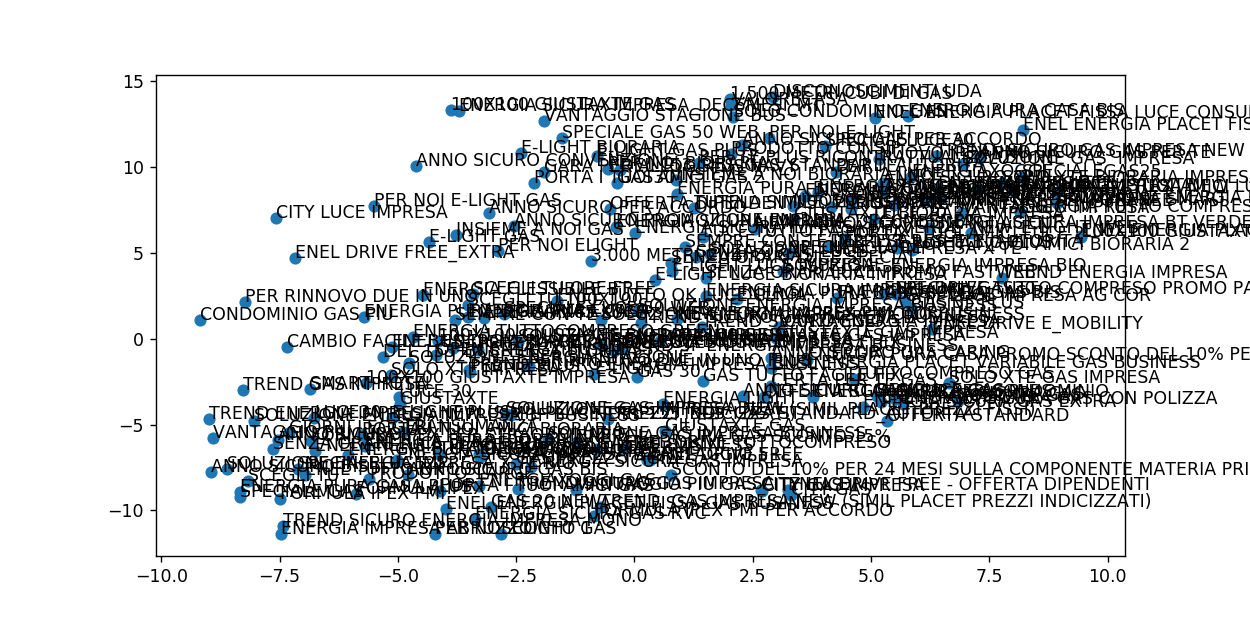

In [33]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['lds_prodotto_listino_2'], size = 10, label = True)

#### 1.1.5.2 - mds_canale_acquisizione

<IPython.core.display.Javascript object>


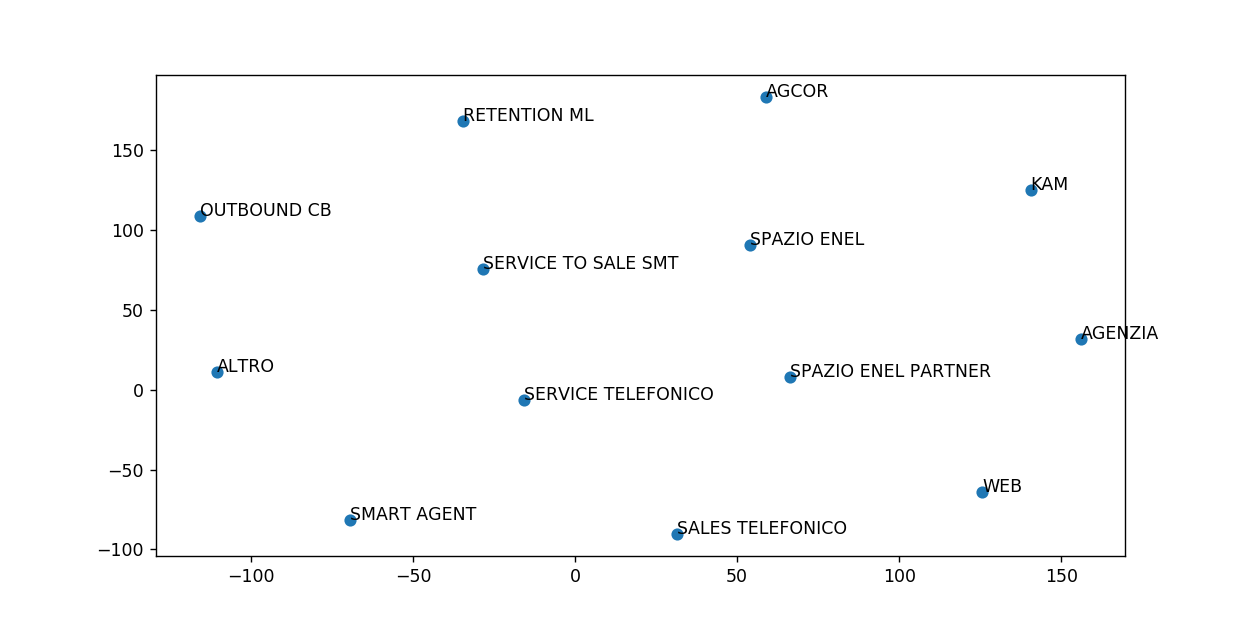

In [34]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['mds_canale_acquisizione'], size = 10, label = True)

#### 1.1.5.3 - cdc_cap_nrm

<IPython.core.display.Javascript object>


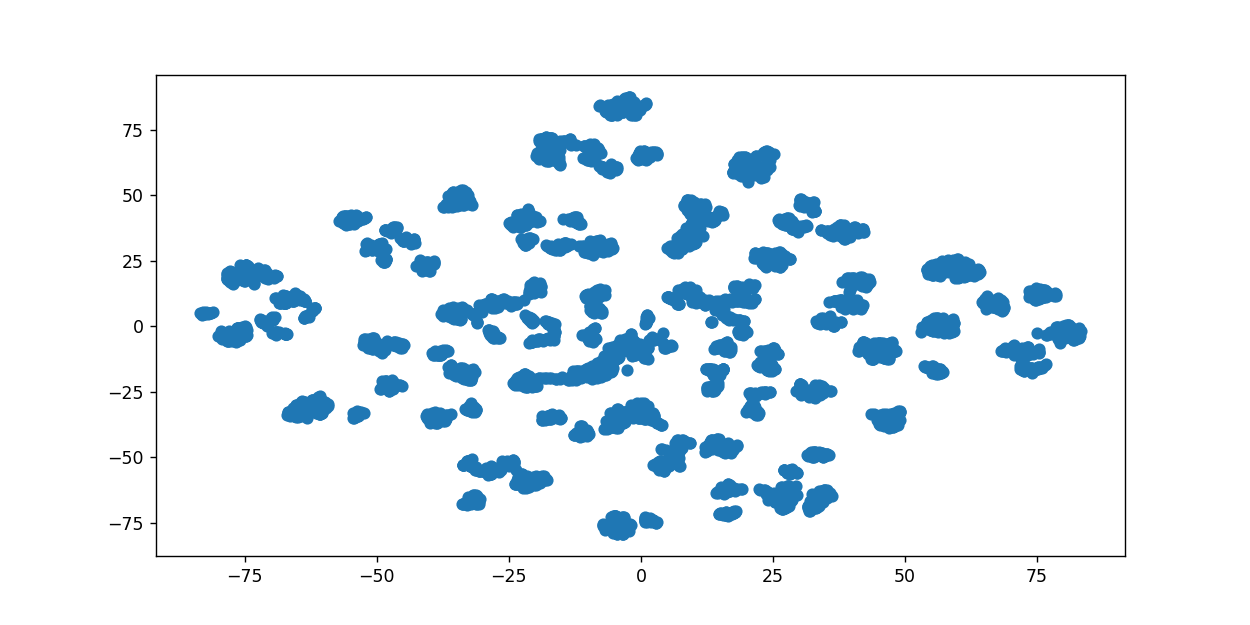

In [35]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['cdc_cap_nrm'], size = 10, label = False)

#### 1.1.5.4 - lds_tipo_uso

<IPython.core.display.Javascript object>


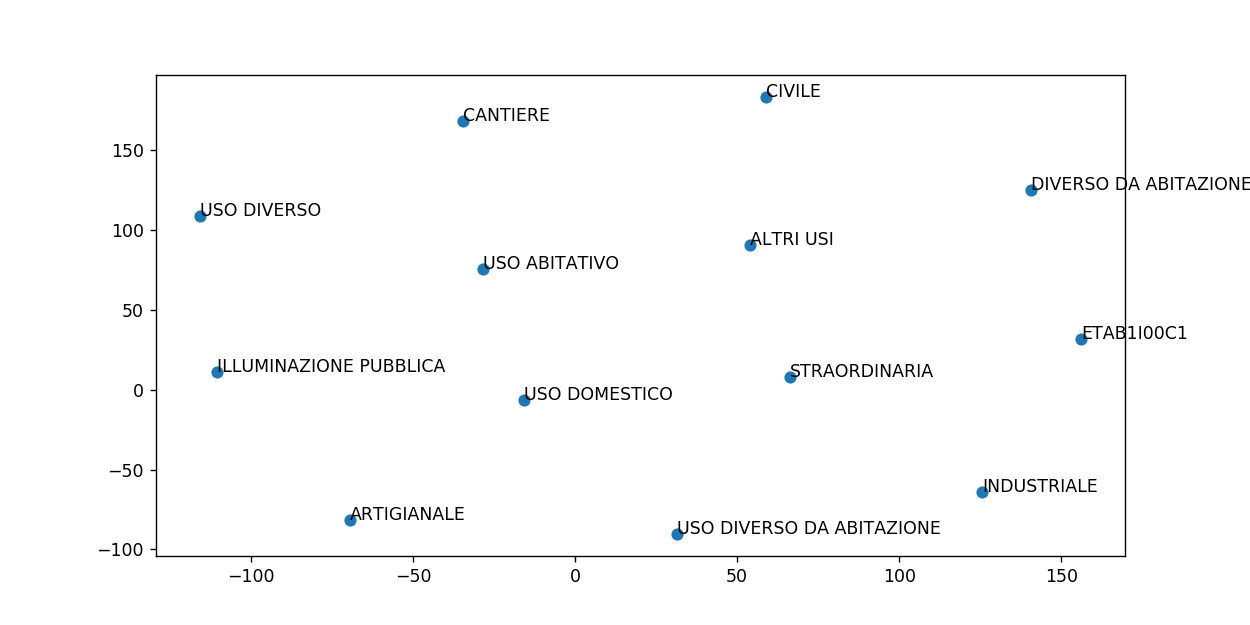

In [36]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['lds_tipo_uso'], size = 10, label = True)

#### 1.1.5.5 - sds_provincia_fatturazione

<IPython.core.display.Javascript object>


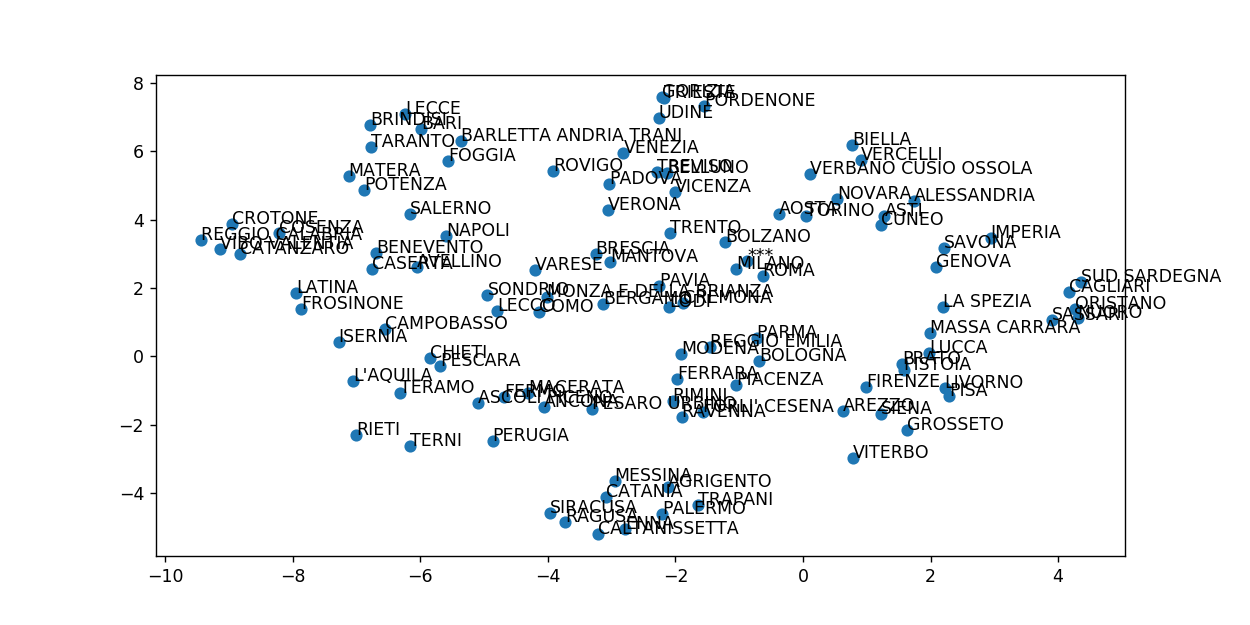

In [37]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['sds_provincia_fatturazione'], size = 10, label = True)

#### 1.1.5.6 - sds_regione_fatturazione

<IPython.core.display.Javascript object>


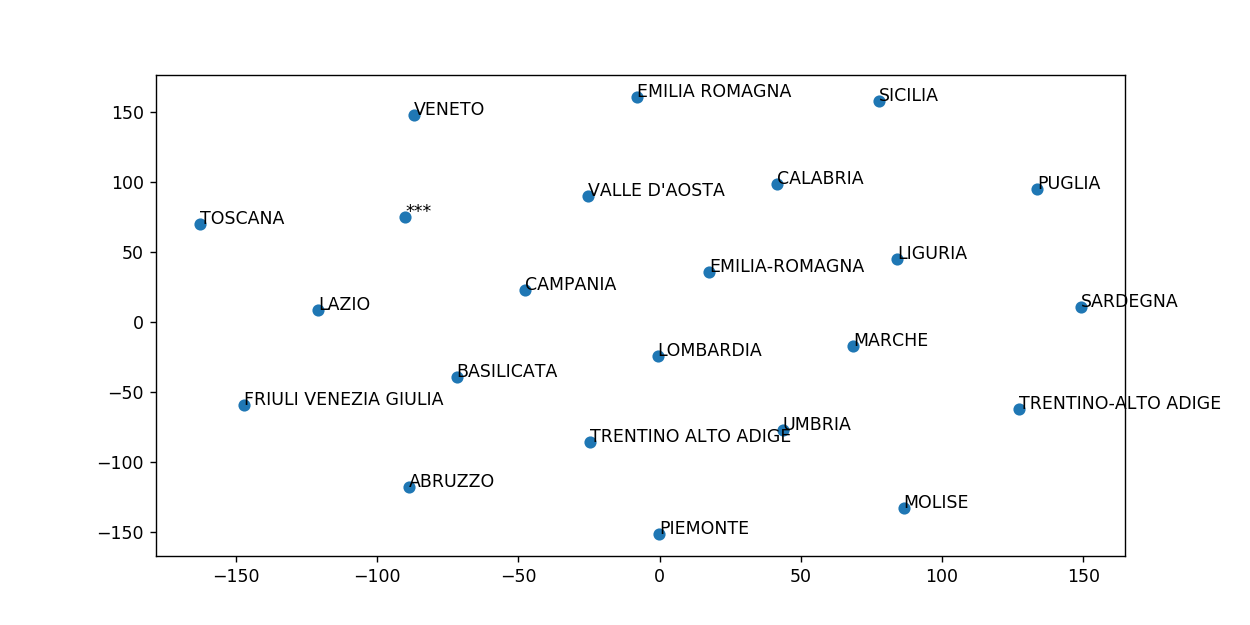

In [38]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['sds_regione_fatturazione'], size = 10, label = True)

#### 1.1.5.7 - lds_societa_vendita

<IPython.core.display.Javascript object>


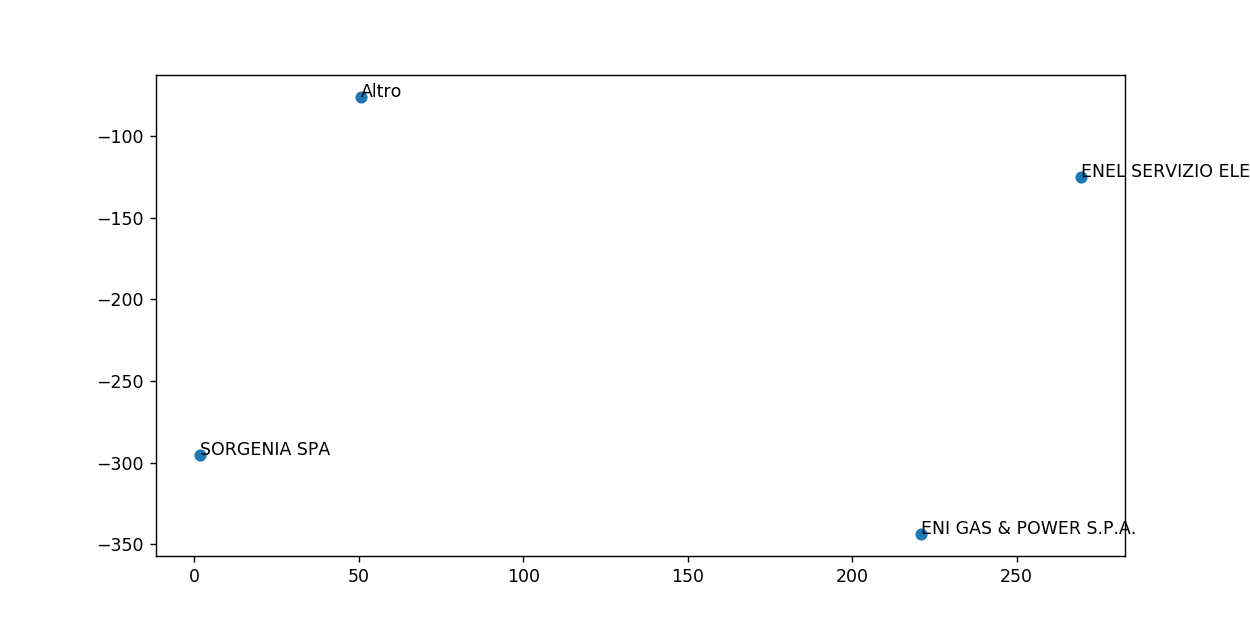

In [39]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['lds_societa_vendita'], size = 10, label = True)

#### 1.1.5.8 - mds_sottocanale

<IPython.core.display.Javascript object>


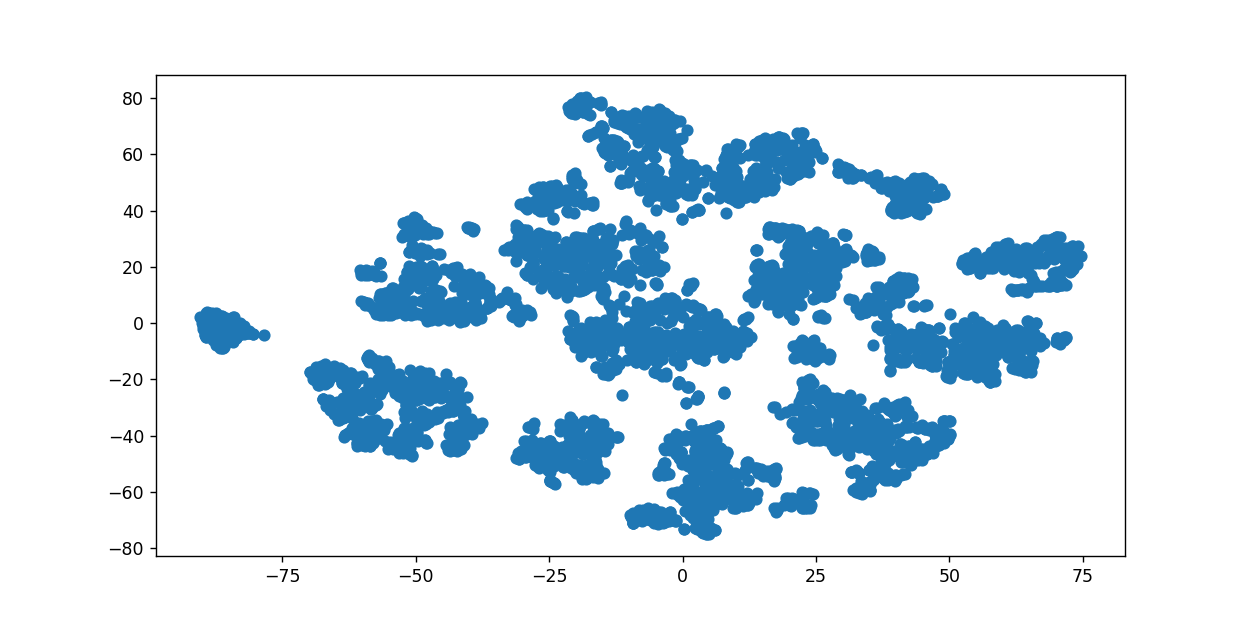

In [40]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['mds_sottocanale'], size = 10, label = False)

#### 1.1.5.9 - cdc_istat

<IPython.core.display.Javascript object>


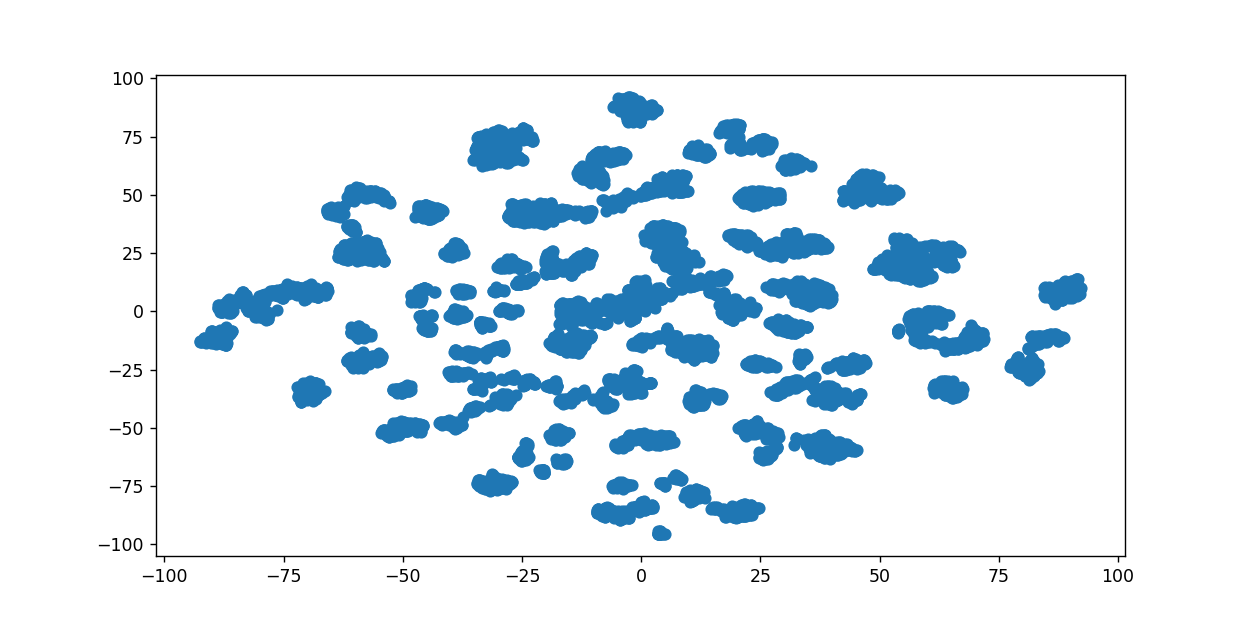

In [41]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['cdc_istat'], size = 10, label = False)

#### 1.1.5.10 - cdc_causale_attivazione

<IPython.core.display.Javascript object>


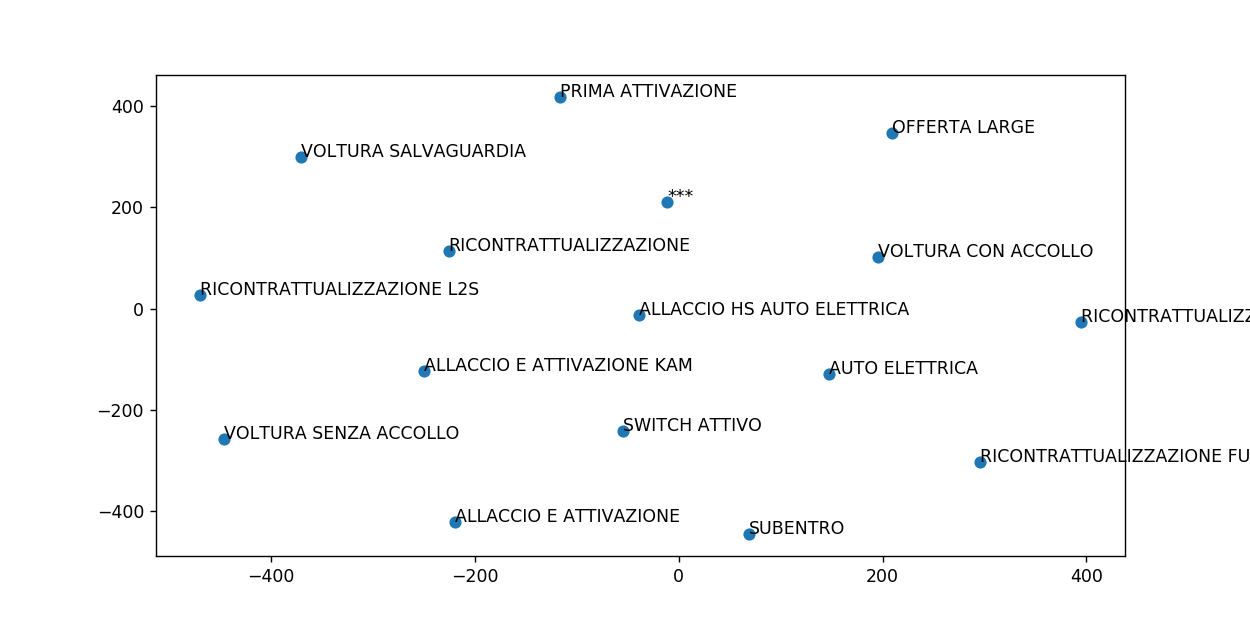

In [42]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['cdc_causale_attivazione'], size = 10, label = True)

#### 1.1.5.11 - lds_comune_fornitura

<IPython.core.display.Javascript object>


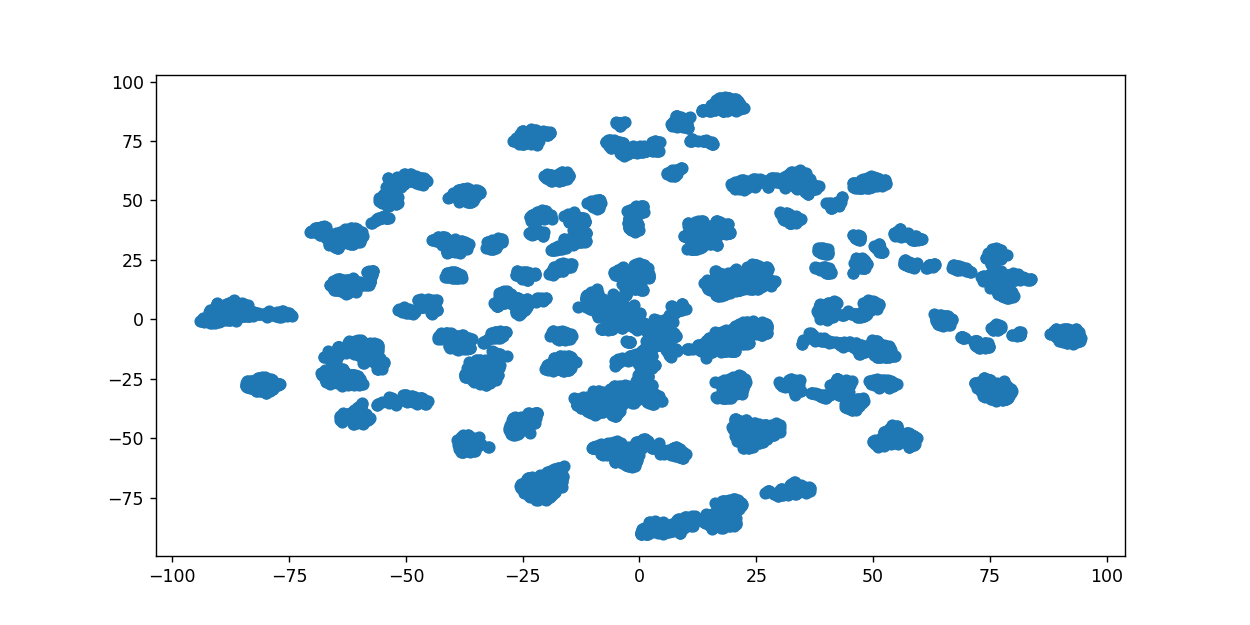

In [43]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['lds_comune_fornitura'], size = 10, label = False)

#### 1.1.5.12 - mds_nome_campagna_last_response_marketing_cli

<IPython.core.display.Javascript object>


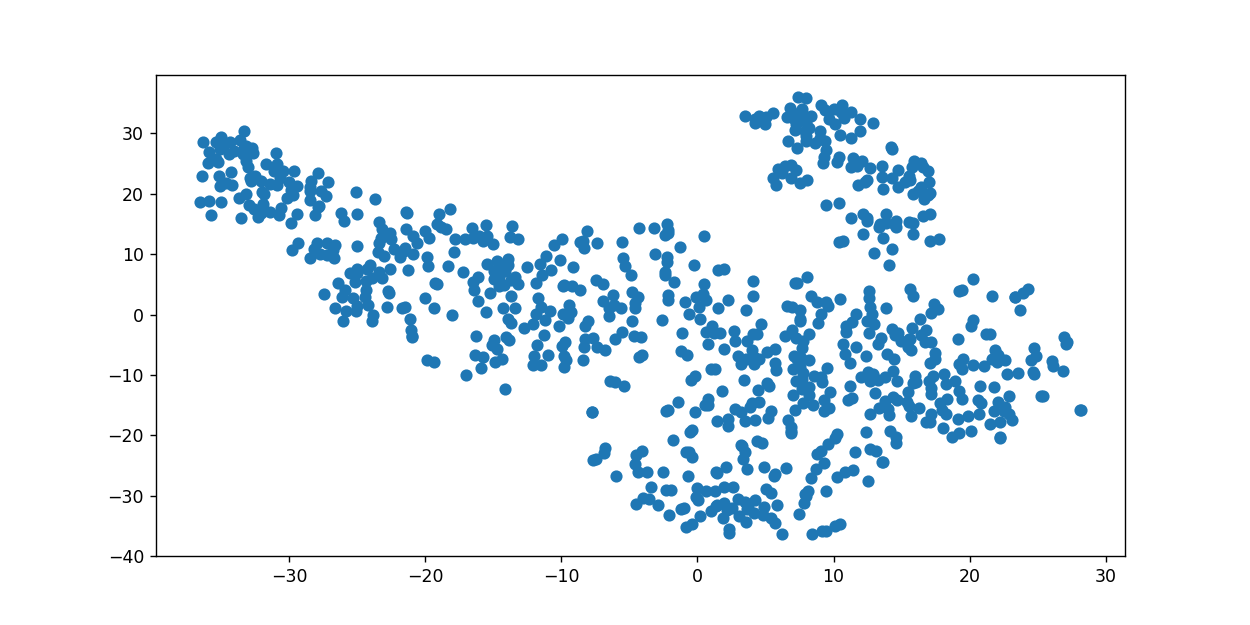

In [45]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['mds_nome_campagna_last_response_marketing_cli'], size = 10, label = False)

#### 1.1.5.13 - xds_canale_last_response_marketing_cli

<IPython.core.display.Javascript object>


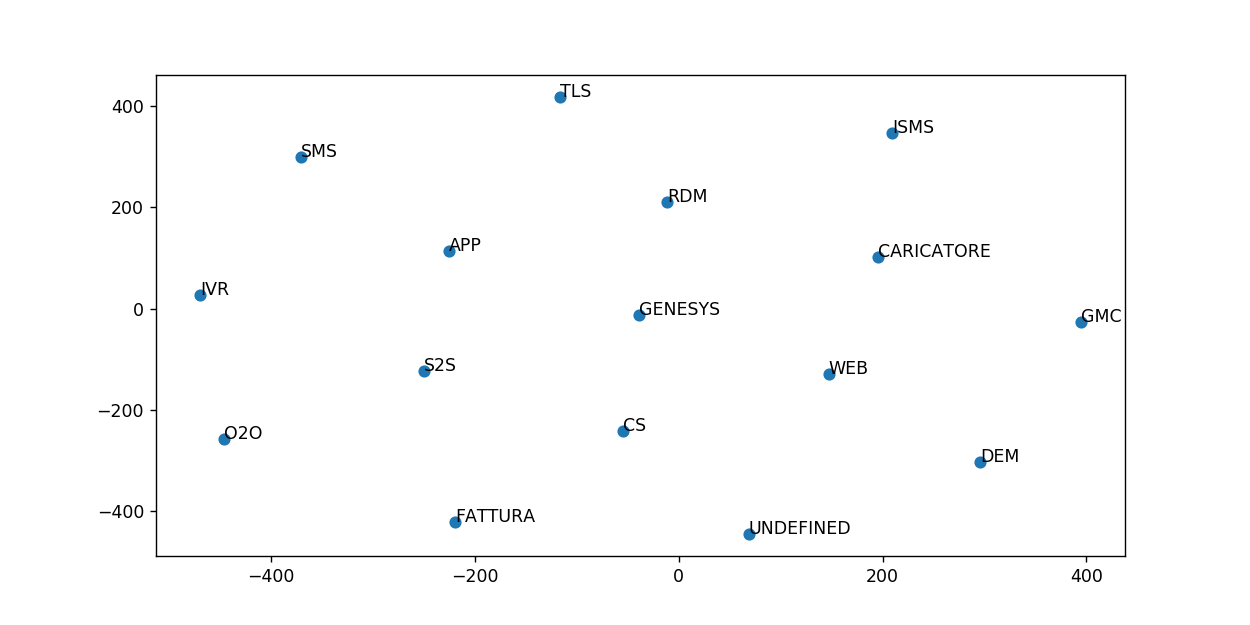

In [46]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['xds_canale_last_response_marketing_cli'], size = 10, label = True)

#### 1.1.5.14 - xds_tipologia_azione_last_response_marketing_cli

<IPython.core.display.Javascript object>


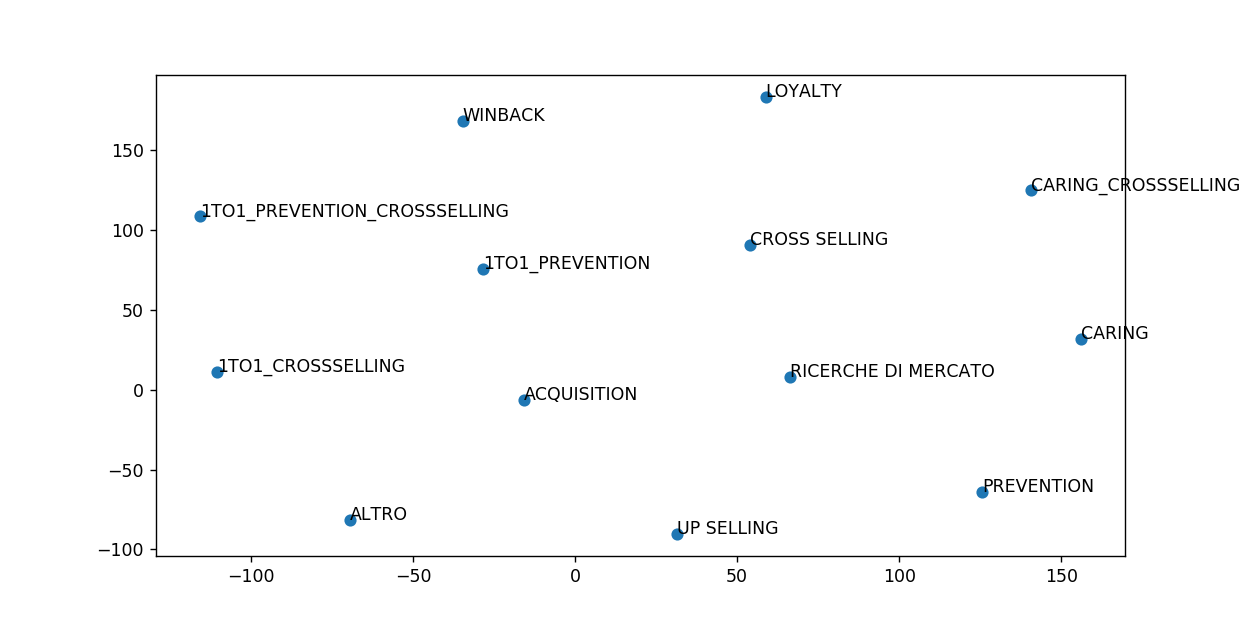

In [47]:
plot_embeddings_TSNE(10, 5, dict_of_embeddings_dicts['xds_tipologia_azione_last_response_marketing_cli'], size = 10, label = True)